# Resit assignment Fundamentals of Machine Learning,

*Corné van den Boogert;
Student number: 1794099;
Date of hand in: 2nd of April, 2021*

---

## Can an algorithm predict if a song belongs in a "Rock" or "Groove" playlist?

From my own experience as a musician, it's always fun to guess if a song is more groovy than rock, or the other way around. As a bassplayer that loves to play both styles of music (Rock and groovy music, such as funk) this seems to be a fun assignemnt to see if an algorithm can do the same with the audiofeatures of Spotify

For this assignment I've used a developer account from spotify, as Spotipy to set up a scraper for the music.

* You can find the developer page for Spotify <a href="https://developer.spotify.com/documentation/web-api/reference/#reference-index">here</a>. 
* You can find the documentation for Spotipy <a href="https://spotipy.readthedocs.io/en/latest/#">here</a>. 
(you need to install Spotipy on the computer that you're using the scraper on.)

---

#### Introduction.

Statistics can help understand an algorithm of what kind of music a user wants to mix and match with, especially with the audio features that Spotify gives to developers but also it's users. By looking up audio features for the scraper, it seems like songs are being matched for playlist as "recommendations", the matched is based on audio features such as 'liveness', 'loudness', 'energy' etc. These features will mix and match certain songs that could be in the same ballpark.
But does this also goes for songs from different genres of music, as a music lover myself this seems to be an adequate question to research.

**PLEASE NOTE, THE SCRAPERS THAT I'VE USED TO COLLECT THE DATA FROM THE DATASETS ARE DISABLED, THIS IS ALSO MENTIONED AT THE SCRAPERS**

For this resit assignment I'll be using 2 different algorithms, **KNN** and the **Random Forest Model**.

Before we start, let's import everything we need for this assignment.

In [1]:
#Everything we need for the spotify scraper, suchs as spotipy
import spotipy
import sys
import spotipy.util as util
from spotipy.oauth2 import SpotifyClientCredentials

#Everything we need to work with dataframes (Such as Pandas) files, and visualize them with seaborn and/or numpy.
import pandas as pd
import numpy as np
import seaborn as sns
import math

#Everything we need for preprocessing dataframes for KNN, but also the confusion matrix and the KNN classifier
from sklearn import preprocessing
from sklearn.metrics import confusion_matrix
from sklearn.neighbors import KNeighborsClassifier

#Everything we need for the classification report, train test and splitting dataframes and the correlation PearsonR
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from scipy.stats.stats import pearsonr

#Everything we need for looking up the mean squared error (prediction model) and the Random Forest model.
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import RandomForestClassifier

#Everything we need to read JSON files, import time for time notations for the scraper.
import matplotlib.pyplot as plt
import json
import time

## Spotify credentials

To start this adventure, let's start with the credentials.
The credentials are needed to login onto our Spotify developer environment. For the sake of the assignment I've kept these blank. The data has already been scraped and this file needs to be uploaded to github!

In [2]:
credentials = spotipy.oauth2.SpotifyClientCredentials(client_id="<clientsID>",client_secret="<clientSECRET>")
spotify = spotipy.Spotify(client_credentials_manager=credentials)

---

## Collecting data, 

After we've installed the Spotipy package from github, we start our data collection with entering credentials
and after that have our custom playlist urls ready.

I made the playlist ID a user input, just for the fun of it (this is also disabled in the scraper for this notebook)

After that everything I need is being exporterd as a JSON file.

### For sake of this assignment, I've disabled to write function of the JSON files, so that the program doesn't update this again and again!

---

### Rock+ playlist

The idea was that I would combine two playlist of my drummer (Rock+ and Groove+) playlist, but the scraper only scrapes the first 100 songs from the playlist, I coudn't find anywhere in the documentation why this happend.
So because this was a slight issue because my dataframe was only 150 rows long, which didn't seem sufficient enough for this assignment. I've added **two** other rock playlists.

The rock playlists are as followed:

* <a href="https://open.spotify.com/playlist/1nwTWLcDoO3kvUHzmcjVTm?si=IWXT-97TTeWo9iE2-nNl3w">Aanrabers: Rock+</a> 
* <a href="https://open.spotify.com/playlist/16XmtROmUNr96KJHKqiUIw?si=nL7OD6qPR-6zcECGwIVIXg">Classic playlist</a> 
* <a href="https://open.spotify.com/playlist/7t5LKw8VMRtPa9fzm8jqlD?si=TwPkG8HrSnCVSHH4wsD5ig">The Future of Rock is Female</a> 

These three playlists are rock playlists that I personaly listen to from time to time, and for me feel as a rock playlist.

In [3]:
# Custom playlist urls
url_groove = 'spotify:playlist:3KrJ7w7ldsF7C7ezl08Myp' # only needed this for the last part of the URI
url_rock = 'spotify:playlist:1nwTWLcDoO3kvUHzmcjVTm'
url_rock_2nd_playlist = 'spotify:playlist:16XmtROmUNr96KJHKqiUIw'
url_rock_3th_playlist = 'spotify:playlist:7t5LKw8VMRtPa9fzm8jqlD'

# Function to extract all the trackids from your playlist
def get_track_ids(playlist_id):
    music_id_list = []
    playlist = sp.playlist(playlist_id)
    for item in playlist['tracks']['items']:
        music_track = item ['track']
        music_id_list.append(music_track['id'])
    return music_id_list

#music_id_list = getTrackIDs('','1nwTWLcDoO3kvUHzmcjVTm')

# Function to extract all the details of each track by passing its id
def get_track_data(track_id):
    meta = sp.track(track_id)
    features = sp.audio_features(track_id)
    track_details = {"name": meta['name'], "album": meta['album']['name'],
                    "artist": meta['album']['artists'][0]['name'],
                     "release_date": meta['album']['release_date'],
                     "duration_in_mins": round((meta['duration_ms'] * 0.001) / 60.0, 2),
                    "acousticness" : features[0]['acousticness'],
                     "danceability" : features[0]['danceability'],
                     "energy" : features[0]['energy'],
                     "instrumentalness" : features[0]['instrumentalness'],
                     "liveness" : features[0]['liveness'],
                     "loudness" : features[0]['loudness'],
                     "speechiness" : features[0]['speechiness'],
                     "tempo" : features[0]['tempo'],
                     "time_signature" : features[0]['time_signature'],}
    
    return track_details

# Get the ids for all the songs in your playlist
#playlist_id = input('Enter the playlist id')
#track_ids = get_track_ids(playlist_id)
#print(len(track_ids))
#print(track_ids)

#Loop over track ids and get their data points
#tracks = []
#for i in range(len(track_ids)):
#    time.sleep(.5)
#    track = get_track_data(track_ids[i])
#    tracks.append(track)

#Save the data collected in a JSON file
#with open('spotify_data_rock_F.json', 'w') as outfile:
#    json.dump(tracks, outfile, indent=4)

---

### Groove+ playlist

This is the exact same scraper of the Rock+ playlist.

The three groove playlists that I've used for the Groove scraper (which is the same as the Rock scraper) are as followed:

* <a href="https://open.spotify.com/playlist/3KrJ7w7ldsF7C7ezl08Myp?si=3yLSfP8fQrK4Ha-RCj_Lag">Aanrabers: Groove+</a>. 
* <a href="https://open.spotify.com/playlist/6DeKeA1pvZiMlk3cYQS8xJ?si=fNd-nM5dQZClu4DYZ61JWA">Groove/Funky/Jazz/Electricguitar/Instrumental</a>. 
* <a href="https://open.spotify.com/playlist/7t5LKw8VMRtPa9fzm8jqlD?si=TwPkG8HrSnCVSHH4wsD5ig">Global Groove</a>. 

In [4]:
client_credentials_manager=SpotifyClientCredentials(client_id="ccf1d1a41da2451fb8ff3e9c4dc6b648",client_secret="a129dd48939d4e40998740440b214a9b")
sp = spotipy.Spotify(client_credentials_manager=client_credentials_manager)

# Custom playlist urls
url_groove = 'spotify:playlist:3KrJ7w7ldsF7C7ezl08Myp'
url_groove_2 = 'spotify:playlist:6DeKeA1pvZiMlk3cYQS8xJ'
url_groove_3 = 'spotify:playlist:37i9dQZF1DWUS3jbm4YExP'

# Function to extract all the trackids from your playlist
def get_track_ids(playlist_id):
    music_id_list = []
    playlist = sp.playlist(playlist_id)
    for item in playlist['tracks']['items']:
        music_track = item ['track']
        music_id_list.append(music_track['id'])
    return music_id_list

#music_id_list = getTrackIDs('','1nwTWLcDoO3kvUHzmcjVTm')

# Function to extract all the details of each track by passing its id
def get_track_data(track_id):
    meta = sp.track(track_id)
    features = sp.audio_features(track_id)
    track_details = {"name": meta['name'], "album": meta['album']['name'],
                    "artist": meta['album']['artists'][0]['name'],
                     "release_date": meta['album']['release_date'],
                     "duration_in_mins": round((meta['duration_ms'] * 0.001) / 60.0, 2),
                    "acousticness" : features[0]['acousticness'],
                     "danceability" : features[0]['danceability'],
                     "energy" : features[0]['energy'],
                     "instrumentalness" : features[0]['instrumentalness'],
                     "liveness" : features[0]['liveness'],
                     "loudness" : features[0]['loudness'],
                     "speechiness" : features[0]['speechiness'],
                     "tempo" : features[0]['tempo'],
                     "time_signature" : features[0]['time_signature'],}
   
    return track_details

# Get the ids for all the songs in your playlist
#playlist_id = input('Enter the playlist id')
#track_ids = get_track_ids(playlist_id)
#print(len(track_ids))
#print(track_ids)

# Loop over track ids and get their data points
#tracks = []
#for i in range(len(track_ids)):
#    time.sleep(.5)
#    track = get_track_data(track_ids[i])
#    tracks.append(track)

# Savind the data collected in a JSON file
#with open('spotify_data_groove_f.json', 'w') as outfile:
#    json.dump(tracks, outfile, indent=4)


---

Now that we have collected 3 playlists as JSON files, let's combine the three groove playlists into one big playlist. And do the same for the three rock playlists.

### Combining JSON files

We start with the groove playlists.
Let's call the first dataframe "df_groove", the second "df_groove_f" and the third dataframe "df_groove_m". We're going to keep the same naming convention for the rock playlists.

In [5]:
df_groove = pd.read_json('spotify_data_groove2.json')
df_groove

,name,album,artist,release_date,duration_in_mins,acousticness,danceability,energy,instrumentalness,liveness,loudness,speechiness,tempo,time_signature
0,Crazy Race,Distractions,The RH Factor,2006-01-01,2.39,0.3640,0.781,0.393,0.000008,0.1070,-12.197,0.1490,101.070,4
1,Leave The Door Open,Leave The Door Open,Bruno Mars,2021-03-05,4.03,0.1820,0.586,0.616,0.000000,0.0927,-7.964,0.0324,148.088,4
2,Strength,Strength,The RH Factor,2004-01-01,4.64,0.1560,0.695,0.507,0.657000,0.1220,-10.014,0.0576,98.855,4
3,All Good,Cut Killer Show 2,Cut Killer,2010-05-26,4.90,0.0222,0.839,0.559,0.000000,0.3520,-9.378,0.3100,99.468,4
4,Step It Up,Step It Up,The Bamboos,2006-03-06,3.65,0.0616,0.735,0.953,0.004010,0.2410,-3.849,0.0665,111.494,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
63,The Ryhthm,The Cat Empire,The Cat Empire,2003-10-24,3.41,0.4550,0.546,0.831,0.000157,0.2870,-6.196,0.0571,118.498,4
64,That Man,Deleted Scenes From The Cutting Room Floor,Caro Emerald,2010-01-29,3.88,0.7570,0.742,0.815,0.003200,0.0797,-5.642,0.1300,206.964,4
65,Down The Road,Tetra,C2C,2012-10-05,3.45,0.0648,0.717,0.592,0.000051,0.0640,-6.168,0.0857,110.993,4
66,Bristlemouth,Deep: The Baritone Sessions,Mark Lettieri,2019-03-01,3.15,0.0156,0.705,0.832,0.921000,0.1000,-6.114,0.0335,120.005,4


In [6]:
df_groove_f = pd.read_json('spotify_data_groove_f.json')
df_groove_f

,name,album,artist,release_date,duration_in_mins,acousticness,danceability,energy,instrumentalness,liveness,loudness,speechiness,tempo,time_signature
0,Red Baron,Spectrum,Billy Cobham,1973,6.61,0.0184,0.609,0.396,0.84900,0.0721,-13.846,0.0440,84.398,4
1,Church,Coolin' Off,Galactic,1996-02-05,5.90,0.5620,0.665,0.426,0.90400,0.1000,-11.557,0.0308,98.381,4
2,Cantaloupe Island,Cantaloupe Island,Herbie Hancock,1994-01-01,5.50,0.3900,0.485,0.551,0.00000,0.0814,-11.115,0.0283,116.162,4
3,Chameleon,Head Hunters,Herbie Hancock,1973-10-26,15.69,0.1040,0.581,0.672,0.85600,0.0458,-8.279,0.0602,111.154,4
4,Tune Down,Sticks,Chris Joss,2015-04-16,4.68,0.3240,0.774,0.540,0.84200,0.1090,-11.830,0.0842,148.032,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,Pulp Funk,The Black City,The Black City,2018-10-01,4.89,0.0133,0.585,0.736,0.00534,0.0947,-8.159,0.2320,200.023,4
96,Love and Happiness,Rass,Monty Alexander,1974,5.36,0.4910,0.537,0.366,0.51400,0.1030,-18.078,0.0464,92.554,4
97,It Ain't No Use,Rejuvenation,The Meters,1974,11.85,0.4500,0.608,0.812,0.73100,0.2600,-12.318,0.0422,107.670,4
98,Walk On By,Doin It!!!!,The Equatics,1972,3.96,0.0198,0.587,0.393,0.73600,0.1450,-12.664,0.0782,142.184,4


In [7]:
df_groove_m = pd.read_json('spotify_data_groove_m.json')
df_groove_m

,name,album,artist,release_date,duration_in_mins,acousticness,danceability,energy,instrumentalness,liveness,loudness,speechiness,tempo,time_signature
0,Dawn at the Souk,Dawn at the Souk,Mr. Käfer,2020-03-18,5.11,0.09590,0.759,0.396,0.9350,0.0903,-14.809,0.0394,109.967,4
1,Pelota,Pelota,Khruangbin,2020-06-16,2.80,0.05250,0.684,0.648,0.4030,0.0841,-11.780,0.0541,103.849,4
2,Silence is Golden,Resonate,Lettuce,2020-05-08,5.73,0.01110,0.741,0.652,0.9470,0.0671,-8.279,0.0431,97.023,4
3,Atlantic Oscillations,Atlantic Oscillations,Quantic,2019-03-12,5.85,0.00833,0.702,0.827,0.8600,0.0884,-8.882,0.0680,121.004,4
4,Vision 9,Vision 9,STR4TA,2021-03-19,7.32,0.31200,0.642,0.809,0.9120,0.1280,-9.882,0.0589,125.041,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,Shepherd Song - Esa & His Afro-Synth Band Version,International Love Affair + Remixes EP,Keleketla!,2020-10-27,5.29,0.00490,0.736,0.609,0.1170,0.2330,-9.167,0.0632,121.012,4
96,Musa Paradisa,Tropic of Tulli,Maajo,2016-10-28,4.73,0.11500,0.809,0.883,0.9140,0.2250,-7.381,0.0600,102.002,4
97,Elevation,Elevation / Baba Meyi,Penya,2021-02-04,3.08,0.29900,0.566,0.700,0.3950,0.0630,-9.439,0.0424,186.017,3
98,Yabaal,"Dur Dur of Somalia - Vol. 1, Vol. 2 (Analog Af...",Dur-Dur Band,2018-09-14,5.96,0.17700,0.621,0.784,0.0973,0.2340,-10.166,0.1110,108.772,4


---

Now that we have the three groove playlists imported (and shown with 'df = pd.read_json(nameDF)', we can add in the rock playlists dataframes.)

---

In [8]:
df_rock = pd.read_json('spotify_data_rock2.json')
df_rock

,name,album,artist,release_date,duration_in_mins,acousticness,danceability,energy,instrumentalness,liveness,loudness,speechiness,tempo,time_signature
0,California Dreamin',California Dreamin',Dirty Honey,2021-03-05,4.31,0.000205,0.458,0.980,0.000063,0.1270,-3.651,0.0808,118.964,4
1,Come Together,Come Together,Gary Clark Jr.,2017-09-08,3.23,0.002570,0.447,0.788,0.000017,0.0744,-4.994,0.0464,80.040,4
2,Apple Pie,Apple Pie,Rafferty,2016-07-11,2.99,0.017000,0.633,0.925,0.000149,0.0889,-4.767,0.0976,117.049,4
3,Beauty,Beauty,Tigercub,2021-01-29,3.67,0.002050,0.475,0.940,0.195000,0.1220,-4.749,0.0573,96.382,4
4,Pressure and Time,Pressure & Time,Rival Sons,2011-06-20,3.28,0.000933,0.406,0.919,0.000099,0.0726,-4.675,0.1030,93.274,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,Kiss Bang,Kiss Bang,grandson,2017-03-03,2.88,0.000233,0.322,0.832,0.218000,0.3640,-4.360,0.0731,78.721,1
96,Bills,Bills,grandson,2016-09-15,2.71,0.003830,0.591,0.855,0.000000,0.2770,-4.602,0.0681,104.959,4
97,Arabella,AM,Arctic Monkeys,2013-09-09,3.46,0.020200,0.579,0.558,0.000001,0.2120,-6.986,0.0895,179.949,4
98,Why'd You Only Call Me When You're High?,AM,Arctic Monkeys,2013-09-09,2.69,0.048300,0.691,0.631,0.000011,0.1040,-6.478,0.0368,92.004,4


In [9]:
df_rock_m = pd.read_json('spotify_data_rock_m.json')
df_rock_m

,name,album,artist,release_date,duration_in_mins,acousticness,danceability,energy,instrumentalness,liveness,loudness,speechiness,tempo,time_signature
0,Another One Bites The Dust - Remastered 2011,The Game (2011 Remaster),Queen,1980-06-27,3.58,0.11200,0.933,0.528,0.312000,0.1630,-6.472,0.1610,109.967,4
1,Bohemian Rhapsody - Remastered 2011,A Night At The Opera (2011 Remaster),Queen,1975-11-21,5.91,0.27100,0.414,0.404,0.000000,0.3000,-9.928,0.0499,71.105,4
2,Lucy In The Sky With Diamonds - Anthology 2 Ve...,Anthology 2,The Beatles,1996-03-18,3.09,0.73200,0.467,0.540,0.000000,0.1510,-8.635,0.0461,134.981,3
3,You Really Got Me - Remastered,The Anthology 1964 - 1971,The Kinks,2014-11-14,2.23,0.14700,0.588,0.948,0.000079,0.0787,-4.073,0.0974,137.294,4
4,All Day And All Of The Night,The Anthology 1964 - 1971,The Kinks,2014-11-14,2.37,0.51200,0.551,0.958,0.000000,0.0762,-2.855,0.0834,136.867,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,Stuck In The Middle With You - Remastered,Stuck In The Middle With You,Stealers Wheel,2009-03-31,3.36,0.11900,0.837,0.496,0.357000,0.1150,-11.821,0.0402,125.017,4
96,Tribute,Tenacious D,Tenacious D,2001-09-09,4.13,0.18100,0.365,0.767,0.000856,0.0942,-6.185,0.0681,94.174,4
97,Kickapoo,The Pick Of Destiny,Tenacious D,2006-11-02,4.24,0.10700,0.501,0.796,0.000974,0.5390,-4.599,0.1040,130.719,4
98,Cats In The Cradle,America's Least Wanted,Ugly Kid Joe,1992-01-01,4.04,0.14300,0.399,0.523,0.000000,0.0769,-9.437,0.0361,74.836,4


In [10]:
df_rock_f = pd.read_json('spotify_data_rock_F.json')
df_rock_f

,name,album,artist,release_date,duration_in_mins,acousticness,danceability,energy,instrumentalness,liveness,loudness,speechiness,tempo,time_signature
0,Daylight,Daylight,Grace Potter,2019-10-25,4.36,0.10800,0.451,0.483,0.000008,0.1010,-8.087,0.0418,130.750,4
1,Shirim,Bon Voyage,Melody's Echo Chamber,2018-06-15,4.78,0.04620,0.648,0.710,0.445000,0.2540,-10.992,0.0607,101.163,4
2,Woman,Lux Prima,Karen O,2019-03-15,2.91,0.00566,0.609,0.889,0.000675,0.0990,-7.501,0.0351,125.954,4
3,Kitchen Sink,Kitchen Sink,Nadine Shah,2020-06-26,3.61,0.44800,0.855,0.501,0.039000,0.0804,-8.614,0.0489,96.055,4
4,Different Kind Of Love,Silences,Adia Victoria,2019-02-22,3.41,0.23800,0.574,0.878,0.065800,0.0737,-5.165,0.0710,124.061,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
76,Incidental Boogie,In A Poem Unlimited,U.S. Girls,2018-02-16,3.39,0.00158,0.522,0.908,0.667000,0.1720,-4.342,0.0350,91.986,4
77,Everyday,Strike A Match,SACRED PAWS,2017-01-27,3.14,0.00321,0.579,0.725,0.000263,0.1150,-8.986,0.0509,123.113,4
78,Money,Late Show,The Beaches,2017-10-13,3.27,0.00106,0.564,0.903,0.001100,0.1440,-5.891,0.0446,142.004,4
79,In The Eve,Far From Earth,Stonefield,2018-04-13,3.94,0.03920,0.150,0.688,0.002780,0.2150,-5.701,0.0395,202.919,4


## Merging the three playlists of rock music,

After importing the dataframes, let's combine the rock playlists.

For this I'm using the 'pd.concat()' method, this seems the best fitting as there isn't really any variables that need to drop, there aren't any Not A Number (NaN) or Not a Value (NaV) in my dataframe. Luckly the scraped data itself is pretty clean.

In [11]:
frames = [df_rock, df_rock_m, df_rock_f]
df_rock_Y = pd.concat(frames)
df_rock_Y

,name,album,artist,release_date,duration_in_mins,acousticness,danceability,energy,instrumentalness,liveness,loudness,speechiness,tempo,time_signature
0,California Dreamin',California Dreamin',Dirty Honey,2021-03-05,4.31,0.000205,0.458,0.980,0.000063,0.1270,-3.651,0.0808,118.964,4
1,Come Together,Come Together,Gary Clark Jr.,2017-09-08,3.23,0.002570,0.447,0.788,0.000017,0.0744,-4.994,0.0464,80.040,4
2,Apple Pie,Apple Pie,Rafferty,2016-07-11,2.99,0.017000,0.633,0.925,0.000149,0.0889,-4.767,0.0976,117.049,4
3,Beauty,Beauty,Tigercub,2021-01-29,3.67,0.002050,0.475,0.940,0.195000,0.1220,-4.749,0.0573,96.382,4
4,Pressure and Time,Pressure & Time,Rival Sons,2011-06-20,3.28,0.000933,0.406,0.919,0.000099,0.0726,-4.675,0.1030,93.274,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
76,Incidental Boogie,In A Poem Unlimited,U.S. Girls,2018-02-16,3.39,0.001580,0.522,0.908,0.667000,0.1720,-4.342,0.0350,91.986,4
77,Everyday,Strike A Match,SACRED PAWS,2017-01-27,3.14,0.003210,0.579,0.725,0.000263,0.1150,-8.986,0.0509,123.113,4
78,Money,Late Show,The Beaches,2017-10-13,3.27,0.001060,0.564,0.903,0.001100,0.1440,-5.891,0.0446,142.004,4
79,In The Eve,Far From Earth,Stonefield,2018-04-13,3.94,0.039200,0.150,0.688,0.002780,0.2150,-5.701,0.0395,202.919,4


#### Merging the three groove playlists.

For the 3 groove playlists I'm using the same method as merging the rock playlists.

In [12]:
framesg = [df_groove ,df_groove_m, df_groove_f]
df_groove_Y = pd.concat(framesg)
df_groove_Y

,name,album,artist,release_date,duration_in_mins,acousticness,danceability,energy,instrumentalness,liveness,loudness,speechiness,tempo,time_signature
0,Crazy Race,Distractions,The RH Factor,2006-01-01,2.39,0.3640,0.781,0.393,0.000008,0.1070,-12.197,0.1490,101.070,4
1,Leave The Door Open,Leave The Door Open,Bruno Mars,2021-03-05,4.03,0.1820,0.586,0.616,0.000000,0.0927,-7.964,0.0324,148.088,4
2,Strength,Strength,The RH Factor,2004-01-01,4.64,0.1560,0.695,0.507,0.657000,0.1220,-10.014,0.0576,98.855,4
3,All Good,Cut Killer Show 2,Cut Killer,2010-05-26,4.90,0.0222,0.839,0.559,0.000000,0.3520,-9.378,0.3100,99.468,4
4,Step It Up,Step It Up,The Bamboos,2006-03-06,3.65,0.0616,0.735,0.953,0.004010,0.2410,-3.849,0.0665,111.494,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,Pulp Funk,The Black City,The Black City,2018-10-01,4.89,0.0133,0.585,0.736,0.005340,0.0947,-8.159,0.2320,200.023,4
96,Love and Happiness,Rass,Monty Alexander,1974,5.36,0.4910,0.537,0.366,0.514000,0.1030,-18.078,0.0464,92.554,4
97,It Ain't No Use,Rejuvenation,The Meters,1974,11.85,0.4500,0.608,0.812,0.731000,0.2600,-12.318,0.0422,107.670,4
98,Walk On By,Doin It!!!!,The Equatics,1972,3.96,0.0198,0.587,0.393,0.736000,0.1450,-12.664,0.0782,142.184,4


### Classifing the rock and groove playlists before merging both dataframes into one big dataframe.

Before adding the rock and groove playlist together, I need to "classify" (or label) both playlist so later when I'm training the data with an algorithm I know which song was from which dataset.

For now I have the following convention:

* **1 is for Rock**
* **0 is for Groove**

I decided to keep it simple as a 1 and a 0, this seems the best way to classify (or label) these playlist when I'm trying to predict a new addition to the playlist.

In [13]:
df_rock_2 = df_rock_Y[["acousticness","danceability","energy","instrumentalness","liveness","loudness","speechiness","tempo","time_signature"]]
df_rock_2['class'] = '1' #this is needed when merging the dataframe, so I know which DF comes from which playlist
df_rock_2

<ipython-input-13-85977c3986ee>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_rock_2['class'] = '1' #this is needed when merging the dataframe, so I know which DF comes from which playlist


,acousticness,danceability,energy,instrumentalness,liveness,loudness,speechiness,tempo,time_signature,class
0,0.000205,0.458,0.980,0.000063,0.1270,-3.651,0.0808,118.964,4,1
1,0.002570,0.447,0.788,0.000017,0.0744,-4.994,0.0464,80.040,4,1
2,0.017000,0.633,0.925,0.000149,0.0889,-4.767,0.0976,117.049,4,1
3,0.002050,0.475,0.940,0.195000,0.1220,-4.749,0.0573,96.382,4,1
4,0.000933,0.406,0.919,0.000099,0.0726,-4.675,0.1030,93.274,4,1
...,...,...,...,...,...,...,...,...,...,...
76,0.001580,0.522,0.908,0.667000,0.1720,-4.342,0.0350,91.986,4,1
77,0.003210,0.579,0.725,0.000263,0.1150,-8.986,0.0509,123.113,4,1
78,0.001060,0.564,0.903,0.001100,0.1440,-5.891,0.0446,142.004,4,1
79,0.039200,0.150,0.688,0.002780,0.2150,-5.701,0.0395,202.919,4,1


In [14]:
df_groove_2 = df_groove_Y[["acousticness","danceability","energy","instrumentalness","liveness","loudness","speechiness","tempo","time_signature"]]
df_groove_2['class'] = '0'
df_groove_2

<ipython-input-14-f139a1ac1bab>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_groove_2['class'] = '0'


,acousticness,danceability,energy,instrumentalness,liveness,loudness,speechiness,tempo,time_signature,class
0,0.3640,0.781,0.393,0.000008,0.1070,-12.197,0.1490,101.070,4,0
1,0.1820,0.586,0.616,0.000000,0.0927,-7.964,0.0324,148.088,4,0
2,0.1560,0.695,0.507,0.657000,0.1220,-10.014,0.0576,98.855,4,0
3,0.0222,0.839,0.559,0.000000,0.3520,-9.378,0.3100,99.468,4,0
4,0.0616,0.735,0.953,0.004010,0.2410,-3.849,0.0665,111.494,4,0
...,...,...,...,...,...,...,...,...,...,...
95,0.0133,0.585,0.736,0.005340,0.0947,-8.159,0.2320,200.023,4,0
96,0.4910,0.537,0.366,0.514000,0.1030,-18.078,0.0464,92.554,4,0
97,0.4500,0.608,0.812,0.731000,0.2600,-12.318,0.0422,107.670,4,0
98,0.0198,0.587,0.393,0.736000,0.1450,-12.664,0.0782,142.184,4,0


---

**Both data sets are labeled!**

Let's add them together (again, with using the pd.concat method) and let's start exploring the data with visualisations of the dataframe.

In [15]:
frames = [df_rock_2, df_groove_2]
result_pl = pd.concat(frames)

Both the mixed and added playlist of rock and groove are added, let's see if my classifier (or label) works.

In [16]:
result_pl

,acousticness,danceability,energy,instrumentalness,liveness,loudness,speechiness,tempo,time_signature,class
0,0.000205,0.458,0.980,0.000063,0.1270,-3.651,0.0808,118.964,4,1
1,0.002570,0.447,0.788,0.000017,0.0744,-4.994,0.0464,80.040,4,1
2,0.017000,0.633,0.925,0.000149,0.0889,-4.767,0.0976,117.049,4,1
3,0.002050,0.475,0.940,0.195000,0.1220,-4.749,0.0573,96.382,4,1
4,0.000933,0.406,0.919,0.000099,0.0726,-4.675,0.1030,93.274,4,1
...,...,...,...,...,...,...,...,...,...,...
95,0.013300,0.585,0.736,0.005340,0.0947,-8.159,0.2320,200.023,4,0
96,0.491000,0.537,0.366,0.514000,0.1030,-18.078,0.0464,92.554,4,0
97,0.450000,0.608,0.812,0.731000,0.2600,-12.318,0.0422,107.670,4,0
98,0.019800,0.587,0.393,0.736000,0.1450,-12.664,0.0782,142.184,4,0


At the end of the columns the column class is visable, with at the top of the dataframe **1** (from the rock playlist), and at the bottom **0** (from the groove playlist).

---

## Data visualisation and exploration

Let's also add a total for the total amount of songs into the playlist. So we can see if there are songs that stand out in each music genre with different kind of audio features.



In [17]:
result_pl['index1'] = result_pl.index
#result_pl['total'] = result_pl.sum(axis=1)
result_pl

,acousticness,danceability,energy,instrumentalness,liveness,loudness,speechiness,tempo,time_signature,class,index1
0,0.000205,0.458,0.980,0.000063,0.1270,-3.651,0.0808,118.964,4,1,0
1,0.002570,0.447,0.788,0.000017,0.0744,-4.994,0.0464,80.040,4,1,1
2,0.017000,0.633,0.925,0.000149,0.0889,-4.767,0.0976,117.049,4,1,2
3,0.002050,0.475,0.940,0.195000,0.1220,-4.749,0.0573,96.382,4,1,3
4,0.000933,0.406,0.919,0.000099,0.0726,-4.675,0.1030,93.274,4,1,4
...,...,...,...,...,...,...,...,...,...,...,...
95,0.013300,0.585,0.736,0.005340,0.0947,-8.159,0.2320,200.023,4,0,95
96,0.491000,0.537,0.366,0.514000,0.1030,-18.078,0.0464,92.554,4,0,96
97,0.450000,0.608,0.812,0.731000,0.2600,-12.318,0.0422,107.670,4,0,97
98,0.019800,0.587,0.393,0.736000,0.1450,-12.664,0.0782,142.184,4,0,98


In [18]:
result_pl['mean'] = result_pl.loc[:, 'acousticness':'tempo'].mean(numeric_only=True, axis=1)
result_pl.head(500)

,acousticness,danceability,energy,instrumentalness,liveness,loudness,speechiness,tempo,time_signature,class,index1,mean
0,0.000205,0.458,0.980,0.000063,0.1270,-3.651,0.0808,118.964,4,1,0,14.619883
1,0.002570,0.447,0.788,0.000017,0.0744,-4.994,0.0464,80.040,4,1,1,9.550548
2,0.017000,0.633,0.925,0.000149,0.0889,-4.767,0.0976,117.049,4,1,2,14.255456
3,0.002050,0.475,0.940,0.195000,0.1220,-4.749,0.0573,96.382,4,1,3,11.678044
4,0.000933,0.406,0.919,0.000099,0.0726,-4.675,0.1030,93.274,4,1,4,11.262579
...,...,...,...,...,...,...,...,...,...,...,...,...
46,0.009780,0.724,0.616,0.887000,0.2880,-7.782,0.0800,181.543,4,0,46,22.045723
47,0.099600,0.752,0.807,0.840000,0.0647,-9.850,0.0609,101.684,4,0,47,11.807275
48,0.013100,0.667,0.607,0.854000,0.1460,-7.756,0.0592,78.108,4,0,48,9.087288
49,0.117000,0.805,0.794,0.315000,0.3150,-7.469,0.0682,104.992,4,0,49,12.492150


Text(0.5, 0, '0 = groove, 1 = rock')

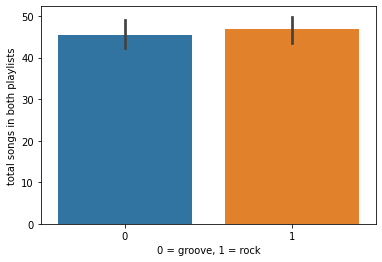

In [19]:
sns.barplot(x="class", y="index1", data=result_pl)
plt.ylabel("total songs in both playlists")
plt.xlabel("0 = groove, 1 = rock")

Total number of songs per genre, as per dataset.

With the way how I labeled the dataset, it seems that there is a _bit_ more rock than groove in my overall dataframe

---

Let's look more into this dataset, we can use scatterplots to discover more about our dataframe, and what playlist have more audiofeatures than other playlists.

Text(0, 0.5, 'songs in playlist')

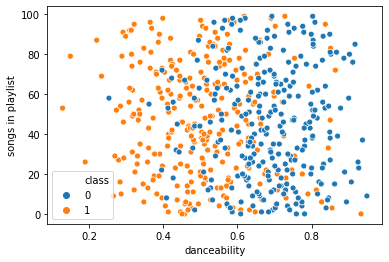

In [20]:
sns.scatterplot(data=result_pl, x="danceability", y="index1", hue="class")
plt.ylabel("songs in playlist")

It seems like **rock** is less 'danceable' than **groove**, seems like a bold statement.

Text(0, 0.5, 'songs in playlist')

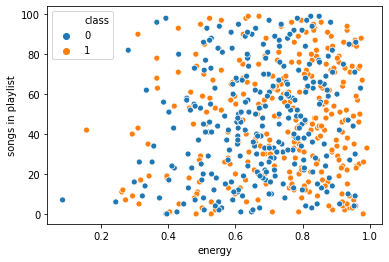

In [21]:
sns.scatterplot(data=result_pl, x="energy", y="index1", hue="class")
plt.ylabel("songs in playlist")

It seems that rock and groove/funk music alsmost has the same 'energy' feature, this one seems interesting and could be correlated probably.

Text(0, 0.5, 'songs in playlist')

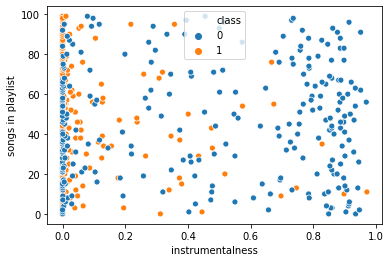

In [22]:
sns.scatterplot(data=result_pl, x="instrumentalness", y="index1", hue="class")
plt.ylabel("songs in playlist")

Here it seems that both genres of music are almost _not_ instrumental, except there are some "groove" songs that seems to be more instrumental. This could be, because in the <a href="https://open.spotify.com/playlist/3KrJ7w7ldsF7C7ezl08Myp?si=foMYvA8hQ3yDBZmSCaxRlg">"Groove+"</a> there are a couple songs that are pure instrumental, from artist suchs as "Vulfpeck", "The Fearless Flyers" and/or "Mark Letteri".

Text(0, 0.5, 'songs in playlist')

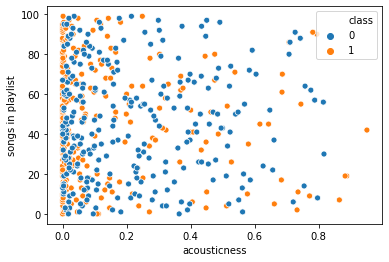

In [23]:
sns.scatterplot(data=result_pl, x="acousticness", y="index1", hue="class")
plt.ylabel("songs in playlist")

It seems, according to this scatterplot that there arent really much songs that have a high acousticness value, this seems that it can be true, as both music genres (Rock and Groovy music) are mostly played with electric instruments (such as bass guitar, synthesizers, electric guitars, vocoders etc.) which give more an electric feel to the music instead of an acoustic feel.

Text(0, 0.5, 'songs in playlist')

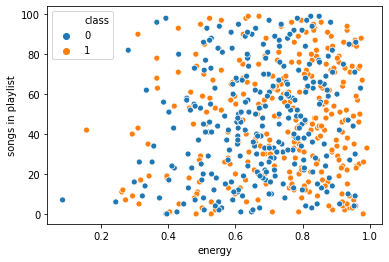

In [24]:
sns.scatterplot(data=result_pl, x="energy", y="index1", hue="class")
plt.ylabel("songs in playlist")

Both playlists seems to have a high chance of having high energy, which for rock and groovy music (such as funk) from a musician point of view seems to be understandable. Higher tempo's and/or high energetick music really gets a crowd going, especially with rock music.

Text(0.5, 1.0, 'Energy in both classes, 0 = groove, 1 = rock')

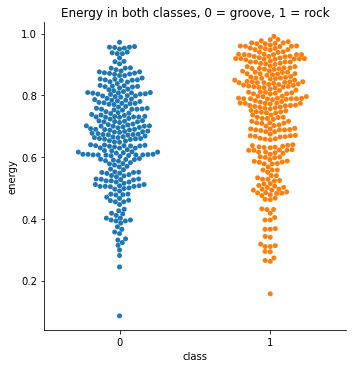

In [25]:
sns.catplot(data = result_pl, x = "class", y = "energy", kind = "swarm") #swarm plot
plt.xlabel("class") 
plt.ylabel("energy")
plt.title("Energy in both classes, 0 = groove, 1 = rock")

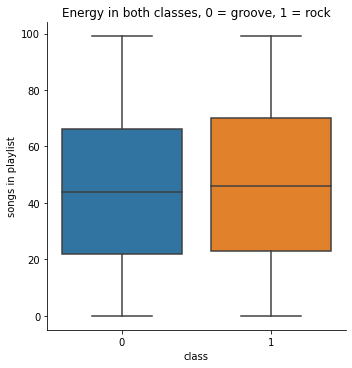

In [26]:
sns.catplot(data = result_pl, x = "class", y = "index1", kind = "box") #box plot
plt.xlabel("class") 
plt.ylabel("songs in playlist")
plt.title("Energy in both classes, 0 = groove, 1 = rock")
plt.show()

Let's look a _tadbit deeper_ into the energy variable. As I've used a catplot as seen above, there are more songs in the playlist that are labeled as **Rock** that have a higher energy value than there are in the **Groove** playlist. It seems that more rocksongs are more energetic than groovy songs, but what we also can see in both graphs is that the medians are very close to each other.
This also can mean that there are only _more songs_ with a higher energy value count in the rock playlist _than_ the groove playlist.

### Correlations, matrixs and Pearsons R

Let's see if there are some correlations between the different kind of audio features that has been scraped earlier from the playlists.

I only use the audiofeatures instead of the song, artist and album names. As they seem irrelevant at this point for labeling or seeing if there are any correlations there.

In [27]:
corr = result_pl[["acousticness","danceability","energy","instrumentalness","liveness","loudness","speechiness","tempo"]].corr()
corr

,acousticness,danceability,energy,instrumentalness,liveness,loudness,speechiness,tempo
acousticness,1.000000,0.105100,-0.498428,0.149283,-0.089855,-0.448737,-0.066491,-0.101743
danceability,0.105100,1.000000,-0.202053,0.229471,-0.215087,-0.139649,0.005864,-0.318370
energy,-0.498428,-0.202053,1.000000,-0.146671,0.128688,0.674253,0.083059,0.252181
instrumentalness,0.149283,0.229471,-0.146671,1.000000,-0.094451,-0.329080,-0.187208,-0.118070
liveness,-0.089855,-0.215087,0.128688,-0.094451,1.000000,0.047944,0.128184,0.054045
loudness,-0.448737,-0.139649,0.674253,-0.329080,0.047944,1.000000,0.069280,0.154231
speechiness,-0.066491,0.005864,0.083059,-0.187208,0.128184,0.069280,1.000000,0.028382
tempo,-0.101743,-0.318370,0.252181,-0.118070,0.054045,0.154231,0.028382,1.000000


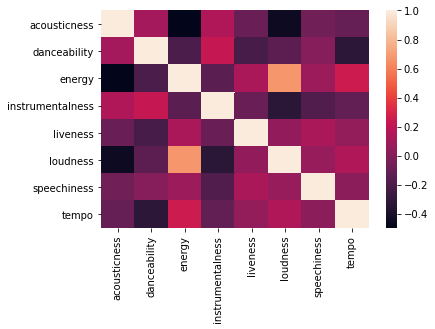

In [28]:
fig = plt.subplots()
sns.heatmap(corr, xticklabels=corr.columns, yticklabels=corr.columns)
plt.show()

Now let's look at _Pearsons R_ with the _P_ Values

In [29]:
print(pearsonr(result_pl["energy"],result_pl["danceability"]))
print(pearsonr(result_pl["energy"],result_pl["acousticness"]))
print(pearsonr(result_pl["energy"],result_pl["instrumentalness"]))
print(pearsonr(result_pl["energy"],result_pl["liveness"]))
print(pearsonr(result_pl["energy"],result_pl["loudness"]))
print(pearsonr(result_pl["energy"],result_pl["speechiness"]))
print(pearsonr(result_pl["energy"],result_pl["tempo"]))

(-0.20205255082686746, 1.8171382708384354e-06)
(-0.4984277807879226, 8.135520557221387e-36)
(-0.14667060353548209, 0.0005659465260653662)
(0.1286875735264993, 0.002519882381361446)
(0.6742533019404071, 4.906314489924817e-74)
(0.08305943778202637, 0.051766425916322946)
(0.25218108885173074, 2.06713525901441e-09)


Now that we have the first correlation visualisation, and looking into the P values. We have the following correlations:

* Energy seems to have a negative mild correlation with danceability. _R_ = -0.20 and _P_ > 1.80
* Energy seems to have no correlation with accousticness. _R_ = -0.49 and _P_ > 8.13
* Energy seems to have a negative mild correlation with instrumentalness. _R_ = -0.14 and _P_ > 0.0006
* Energy seems to have a mild positive correlation with liveness. _R_ = 0.13 and _P_ > 0.003
* Energy seems to have a strong correlation with loudness. _R_ = 0.67 and _P_ > 4.90
* Energy seems to have a mild correlation with speechiness. _R_ = 0.08 and _P_ > 0.051
* Energy seems to have a positive correlation with tempo. _R_ = 0.25 and _P_ > 2.1

Therefour, I will take these variables into my prediction models, some correlations are not as strong, but probably will help to make the model better.

## Building the first predictive model with KNN

For starting with a predictive model, I've used K-Nearest-Neighbor to make the first predictive model.

**How does KNN works?**
The algortihm isn't all magick and black voodoo, luckly I can explain it in a couple of steps.

* Step 1: Acquire data, look for correlations and make a test model
* Step 2: Choose the K-Neighbors, and by this we define K.
* Step 3: The new data points takes the K nearest neighbor, and measures the distance between tose neighbors. This distance is called Eucledean distance (not only "up" and "down", but also 8-dimensional distance)
* Step 4: Among these neighbors, KNN (or the algorithm) counts the number of data-points in each category, on wich this algorithm can make a prediciton
* Step 5: The algorithm assings the new recieved data points and assigns them to the category with the most neighbors.

And with this out of the way, let's start making the model!

We first need to split the data frame in a "X" and "Y" axis.
For the Y variable I've chosen the "class" variable, which was the "label" for which song is from which playlist (0 = groove and 1 = rock).

For now I've chosen to have 7 neighbors for this assignment, the number 7 is mostly used in K-Nearest Neighbor and seemed like a good start.

Also the test size is rather small, it only takes 0.3 of the dataframe. The random state is set to '1' so that everytime this notebook reloads the outcome stays the same of the KNN algorithm.

In [30]:
from sklearn.preprocessing import normalize
from sklearn.model_selection import train_test_split

X = result_pl[['acousticness','danceability','energy','instrumentalness','liveness','loudness','speechiness','tempo']] #create the X matrix
X = normalize(X) #normalize the matrix to put everything on the same scale

y = result_pl['class'] #create the y-variable
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1) #split the data, store it into different variables

X_train

array([[ 5.02295850e-04,  6.54419736e-03,  6.19976592e-03, ...,
        -1.12705621e-01,  5.17603914e-04,  9.93579461e-01],
       [ 3.79310181e-03,  6.92607817e-03,  7.22994544e-03, ...,
        -9.49323271e-02,  5.15526544e-04,  9.95395836e-01],
       [ 4.15202702e-03,  5.60984984e-03,  7.49210209e-03, ...,
        -1.13654820e-01,  3.89367867e-04,  9.93441665e-01],
       ...,
       [ 4.57139380e-05,  5.94880066e-03,  8.09476064e-03, ...,
        -5.49066316e-02,  5.85896978e-04,  9.98440316e-01],
       [ 9.00165077e-06,  4.94272460e-03,  6.45663860e-03, ...,
        -5.12193929e-02,  2.23404605e-04,  9.98626770e-01],
       [ 1.31651258e-06,  2.93378019e-03,  3.98358548e-03, ...,
        -3.88257719e-02,  2.40604023e-04,  9.99233049e-01]])

In [31]:
knn = KNeighborsClassifier(n_neighbors=7) #create a KNN-classifier with 7 neighbors
knn = knn.fit(X_train, y_train) #this fits the k-nearest neigbor model with the train data
knn.score(X_test, y_test) #calculate the fit on the test data

0.7575757575757576

The score out of this dataset seems to be $76%$%, which means that the algorithm could be highlikely right when predicting an entry, or song.

---

### Evaluating the model: KNN classifier

In [32]:
y_test_pred = knn.predict(X_test) #the predicted values
cm = confusion_matrix(y_test, y_test_pred) #creates a "confusion matrix"
cm

array([[58, 27],
       [13, 67]])

In [33]:
conf_matrix = pd.DataFrame(cm, index=['Groove Predicted (actual)', 'Rock Predicted (actual)'], columns = ['Groove Predicted (predicted)', 'Rock predicted (predicted)']) 
conf_matrix

,Groove Predicted (predicted),Rock predicted (predicted)
Groove Predicted (actual),58,27
Rock Predicted (actual),13,67


What the confusion matrix tells us is that there are 67 rightly predicted by the KNN.

In [34]:
print(classification_report(y_test, y_test_pred))

              precision    recall  f1-score   support

           0       0.82      0.68      0.74        85
           1       0.71      0.84      0.77        80

    accuracy                           0.76       165
   macro avg       0.76      0.76      0.76       165
weighted avg       0.77      0.76      0.76       165



Before making a prediction with another model, let's make a last classification report about the KNN algorithm.

By looking at the first classification report, we can read the following:
* Accuracy for 0 (Groove) is 0.76 while for 1 (Rock) seems to be almost the same, as it is 0.77
* Recall for 0 (Groove) is 0.68 and 1 (Rock) 0.84
* Precision for 0 (Groove) is 0.82, while for 1 (Rock) 0.71, which seems a lot lower.

Let's see what the result is while making a KNN with more (or less) neighbors.
I started with 1 neighbors, and upto 9 neighbors to see what the result is.

In [35]:
from sklearn.metrics import classification_report

for i in range(1,10):
    knn_new = KNeighborsClassifier(n_neighbors = i) 
    knn_new = knn_new.fit(X_train, y_train) #fit new model on train data
    y_test_pred_new = knn_new.predict(X_test) #predict using new model, with test data
    print(f"With {i} neighbors the result is:")
    print(classification_report(y_test, y_test_pred_new)) #use a built-in function to print out accuracy, precision and recall

With 1 neighbors the result is:
              precision    recall  f1-score   support

           0       0.70      0.69      0.70        85
           1       0.68      0.69      0.68        80

    accuracy                           0.69       165
   macro avg       0.69      0.69      0.69       165
weighted avg       0.69      0.69      0.69       165

With 2 neighbors the result is:
              precision    recall  f1-score   support

           0       0.69      0.84      0.76        85
           1       0.77      0.60      0.68        80

    accuracy                           0.72       165
   macro avg       0.73      0.72      0.72       165
weighted avg       0.73      0.72      0.72       165

With 3 neighbors the result is:
              precision    recall  f1-score   support

           0       0.79      0.72      0.75        85
           1       0.73      0.80      0.76        80

    accuracy                           0.76       165
   macro avg       0.76      0.7

It seems like more neighbors aren't helpfull for the algorithm, as with 8 neighbors the precision for 0 (groove) seems to be lower, while for 1 (rock) seems to be a tadbit higher.

---

# Random forest model

Random forest is a learning algorithm that uses decision trees to come up with an output for a dataset.

Random forest uses the following steps to learn and give an outcome:

* First, it creates a bootstrap of the dataset by randomly selecting rows from the dataset.
* Second, it constructs a descicion tree using the bootstrap dataset from random variables from different variables and uses it as the root of the tree.
* Third, these steps are repeated untill the "n_estimators" counter has been compleeted (so for this study it's 100), once new data is being fed to the algorithm, the data enters the descision tree and predictions happens in said tree by a voting process.
* Lastly, the final outcome is based on the most votes in the descision tree.

We already had our data set ready, let's use it again to split it and train the set for the Random Forest model.
I'm keeping the test size the same (0.3) as KNN and the random state also at 1 for the same outcome.

In [36]:
# Creating the independant variable X
X = result_pl[['acousticness','danceability','energy','instrumentalness','liveness','loudness','speechiness','tempo']] #create the X matrix
#X = normalize(X) #normalize the matrix to put everything on the same scale

# Creating the dependant variable Y
y = result_pl['class'] #create the y-variable
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1)

In [37]:
# Building the model
rf_classifier = RandomForestClassifier(random_state=1, n_estimators=100)
# training the model
rf_classifier = rf_classifier.fit(X_train, y_train)

In [38]:
y_test_p = rf_classifier.predict(X_test)

In [39]:
rf_classifier.score(X_test, y_test)

0.8484848484848485

Our model has an $R^2$ score of 0.84, which is good. $R^2$ tell us how well my model fits the data of my dataframe.
For this research it seems that the prediction is near the actual data output of my model (it's only "16%" off, or "84%" right in lazymens terms.
<br><br>
The $R^2$ is calculated in the following way $R^2 = 1 - {RSS}/{TSS} $. Where RSS is the sum of the squared residuals and TSS is the total sum of squares.

Before making the last confusion matrix, let's take a look to the Root Mean Squared Error in our model. It measures the differences of values predicted by our model and the observed values from that model. It measures how off our predictions are.

In [40]:
math.sqrt(mean_squared_error(y_test, y_test_p))

0.3892494720807615

Based on the _Mean Squared Error_ , it has a typical error rate of almost 0.40.

In [41]:
rf_classifier.classes_

array(['0', '1'], dtype=object)

In [42]:
cm = confusion_matrix(y_test, y_test_p)
cm = pd.DataFrame(cm, index = ["Groove (Actual)", "Rock (Actual)"], columns= ["Groove (Predicted)", "Rock (Predicted)"])
cm

,Groove (Predicted),Rock (Predicted)
Groove (Actual),67,18
Rock (Actual),7,73


What the confusion matrix tells us is that there are 73 songs predicted right, and predicted 18 that the Random Forest model thought were Rock but were actually groove.

In [43]:
print(classification_report(y_test, y_test_p))

              precision    recall  f1-score   support

           0       0.91      0.79      0.84        85
           1       0.80      0.91      0.85        80

    accuracy                           0.85       165
   macro avg       0.85      0.85      0.85       165
weighted avg       0.86      0.85      0.85       165



By seeing the last classification rapport from the Random Forest Model we can conclude these following things:

* This model has an accuracy of 0.91 for 0 (Groove) and 0.80 for 1 (Rock).
* This model has a precision value of 0.91 for 0 (Groove) and 0.80 for 1 (Rock), so about 80% of the predictions was actual a rock song, and 91 a "groovy" song.
* This model has a recall value of 0.79 for Groove songs and 0.91 for Rock songs.

The overall results are very good, but still this could use much more improvement, there could be added more variables to this dataframe for looking into stronger (or more) correlations, such as datamining song names or artist namens and see if there are any correlations whatsoever.

**as seen as the outcome from the classification report from the Random Forest Model it seems like this model is better suited to make the predictions needed for this research**


---

# Conclusion

During this research, as seen in this notebook, I've tried to build two models that can predict which song comes from 'which playlist', or has 'what genre a song is'. In a real world setting, or a setting less placed in a vacuum such as scraped playlists there can be more variables that has a part into what defines a song for it's genre.
*Rock* music has it's roots shared with *Groovy* music, they both come from blues and Rythm and Blues music styles, which followed Jazz and Rock and Roll. So in hindsight it's easy to tell them apart now because the music genres are so progressive on themselves, but given the location where the song originates from, what the culture or timeframe was of the writti song has a very big impact on what the genre could be. A good example is music such as Black Sabbath, when they started everyone called it "Black Metal" or "Metal", now a days it's almost a classick rock band for the "Metal purists" out there.

Should this mean that an algorithm can't predict genres? Ofcourse it can, the last couple of years it seems like most spotify recommendations are spot on. Even I'm surprised as a bass player how well spotify knows my music taste, and gives really good recommendations based on that.
However, for this research I would recommend making a bigger dataframe which the algorithm could train itself on (in this case Random Forest), as there could be more variables out there to have an impact on the outcome of the prediction.